In [1]:
!pip install nltk
!pip install seaborn

     |████████████████████████████████| 1.5 MB 447 kB/s eta 0:00:01
     |████████████████████████████████| 785 kB 37.2 MB/s eta 0:00:01
     |████████████████████████████████| 294 kB 254 kB/s eta 0:00:01


In [2]:
import numpy as np
import pickle
import pandas as pd

import nltk
from nltk.tokenize import word_tokenize
from tqdm import tqdm, trange
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import enum
nltk.download('punkt_tab')

<frozen importlib._bootstrap>:219: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject
[nltk_data] Downloading package punkt_tab to /home/jovyan/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


True

In [3]:
def analyzeSentences(sentences, stop_words, alphabet, availableLetters):
  meanWordLength = []
  meanSentenceLength = []
  char_sum = 0

  pbar = tqdm(sentences)

  for sentence in pbar:
    words = word_tokenize(sentence)
    words = [word for word in words if word not in stop_words]
    wordsLength = [len(word) for word in words]

    meanWordLength.append(np.mean(wordsLength))
    meanSentenceLength.append(len(sentence))

    words = "".join(words)
    for char in words:
      if char in availableLetters:
        alphabet[char] += 1
        char_sum += 1

  print(f'\nMean word`s length: {np.mean(meanWordLength)}')
  print(f'Mean sentence`s length: {np.mean(meanSentenceLength)}')
  print(f'Count of letters: {char_sum}')
  print('-'*20)

  letters = np.array(list(alphabet.keys()))
  count = np.array(list(alphabet.values()), dtype='float32')

  data = {
    'letters': letters,
    'count': count,
    'frequency': count/char_sum,
    'freq%': (count/char_sum)*100,
    'priority': 1 - (count/char_sum)
  }

  df = pd.DataFrame(data)

  return df, meanWordLength, meanSentenceLength

In [4]:
class generation_strategy(enum.Enum):
  by_const = 'by-const'
  by_percentage = 'by-percentage'
  by_size = 'by-size'

# Поиск возможных замен (генерация, оценка)
def get_index(lst, targets):
  lst = np.array(lst)
  indices = np.asarray([], dtype='int32')
  for target in targets:
    temp = np.where(lst == target)[0]
    indices = np.concatenate([indices, temp], dtype='int32')
  return indices

# Изменение символов строки на ее омоглифы
def perturbate(homoglyphs, words, strategy, priority, min_perturb=1, max_perturb=1, limits=[]):
  glyphs_list = list(glyphs.keys())
  order = dict(zip(glyphs_list, np.zeros(len(glyphs_list), dtype=np.int32)))
    
  data = []
  target = list(homoglyphs.keys())
  pbar = tqdm(words)
  for word in pbar:
    w = list(word)
    list_index = get_index(w, target)

    if strategy == generation_strategy.by_const:
      if len(list_index) >= min_perturb:
        max_perturb = min(len(list_index), max_perturb)
      else:
        max_perturb = len(list_index)
        min_perturb = 1
    elif strategy == generation_strategy.by_percentage:
      min_perturb = max(round(len(w)*min_perturb), 1)
      max_perturb = round(len(w)*max_perturb)
    elif strategy == generation_strategy.by_size:
      for limit in limits:
        if len(w) <= limit[0]:
          min_perturb = max(round(len(w)*limit[1]), 1)
          max_perturb = round(len(w)*limit[2])
          break
        else:
          min_perturb = 1
          max_perturb = round(len(w)*0.055)

    for perturb in range(min_perturb, max_perturb + 1):

      char_priority = [(priority[word[idx]], idx) for idx in list_index]
      index = np.sort(char_priority, axis=0)[-perturb:,1][::-1].astype(np.int32)

      for i in index:
        w[i] = homoglyphs[word[i]][order[word[i]]]
        order[word[i]] = (order[word[i]] + 1) % len(homoglyphs[word[i]])
      data.append(["".join(w), word])
      w = list(word)

  return data

In [4]:
with open('data/homoglyphs.pkl', 'rb') as file:
    glyphs = pickle.load(file)

In [6]:
with open('data/dictionary_sentences_balanced.pkl', 'rb') as file:
    sentences = pickle.load(file)
len(sentences)

376410

In [7]:
analysis = pd.read_csv('data/analysis.csv')
analysis['priority'] = 1 - analysis['frequency']
priority = dict(analysis.set_index('letters')['priority'].to_dict().items())
analysis.head()

,letters,count,frequency,freq%,priority
0,a,738459.0,0.040478,4.047799,0.959522
1,b,146279.0,0.008018,0.801816,0.991982
2,c,318495.0,0.017458,1.745803,0.982542
3,d,292509.0,0.016034,1.603363,0.983966
4,e,1035870.0,0.056780,5.678032,0.943220


In [55]:
strategy = generation_strategy.by_size
limits = [(50, 0, 0.75), (150, 0, 0.4), (300, 0, 0.1)]

dataset = perturbate(glyphs, sentences, strategy, priority, limits=limits)
len(dataset)

100%|██████████| 376410/376410 [04:38<00:00, 1349.99it/s]


8872562

In [56]:
with open('data/dictionary_dataset_balanced_8m.pkl', 'wb') as file:
    pickle.dump(dataset, file)

In [57]:
dataset = np.array(dataset)

In [5]:
with open('data/dictionary_dataset_balanced_8m.pkl', 'rb') as file:
    dataset = pickle.load(file)
len(dataset)

8872562

In [8]:
np.random.seed(42)
np.random.shuffle(dataset)
dataset_small = dataset[:len(dataset)//4]

In [11]:
dataset_small[:5]

[['A SLENDER BONY OR CARTILAGINOUS PROCESS DEVELOPED FROM THE HEEL BONE OF BATS. IT HELPS TO SUPPORT THE WING MEMBRANES. SEE ILLUST. ΟḞ ÇΗĘꞮⱤƠṔΤẸƦ.',
  'A SLENDER BONY OR CARTILAGINOUS PROCESS DEVELOPED FROM THE HEEL BONE OF BATS. IT HELPS TO SUPPORT THE WING MEMBRANES. SEE ILLUST. OF CHEIROPTER.'],
 ['DESIGNED TO BE WORN OR PLACED INWARD; AS  THE WRONG SIDE OF A GARMENT OR OF A PIECE OF CLOṬꞪ.',
  'DESIGNED TO BE WORN OR PLACED INWARD; AS  THE WRONG SIDE OF A GARMENT OR OF A PIECE OF CLOTH.'],
 ['THE WHOLE ARRANGEMENT  OR ONE RANGE OF THE KEYS OF AN ORꞬⱭṈ ṪʏƤẸᴡƦΙŢĖṞ ΕΤС.',
  'THE WHOLE ARRANGEMENT  OR ONE RANGE OF THE KEYS OF AN ORGAN TYPEWRITER ETC.'],
 ['HAVING GRADUAL  ROUNDED UNDULATIONS OF SURFACE; AS A ROLLING COUŅṪṞȲ; ṚỎI1ÌṈĠ IẠṆḎ.',
  'HAVING GRADUAL  ROUNDED UNDULATIONS OF SURFACE; AS A ROLLING COUNTRY; ROLLING LAND.'],
 ['Alt. of Zymosimeƫȩŗ', 'Alt. of Zymosimeter']]

In [7]:
glyphs_dict = sum(list(glyphs.values()), [])
stop_words = ['.', ',', ';', ':', '?', '!', "'", '``', '`', '(', ')', '<', '>', '=', '{', '}', '/', '|', '~', '^', '%', '+', '-', '$']
alphabet = {}

for char in glyphs_dict:
  alphabet[char] = 0


df, meanWordLength, meanSentenceLength = analyzeSentences([x[0] for x in dataset], stop_words, alphabet, glyphs_dict)
df.head()

100%|██████████| 8872562/8872562 [19:57<00:00, 7411.27it/s] 



Mean word`s length: 5.019483909335402
Mean sentence`s length: 77.09960099461689
Count of letters: 172199506
--------------------


,letters,count,frequency,freq%
0,à,1185354.0,0.006884,0.688361
1,ɑ,1185354.0,0.006884,0.688361
2,ạ,1185354.0,0.006884,0.688361
3,ą,1185354.0,0.006884,0.688361
4,а,1185354.0,0.006884,0.688361


In [13]:
df.sort_values('count', ascending=False)

,letters,count,frequency,freq%
179,I,4310484.0,0.100143,10.014296
56,i,4176718.0,0.097035,9.703525
55,1,841800.0,0.019557,1.955705
68,0,469891.0,0.010917,1.091670
21,ė,424883.0,0.009871,0.987106
...,...,...,...,...
48,ĵ,3956.0,0.000092,0.009191
47,ɉ,3899.0,0.000091,0.009058
49,ϳ,3875.0,0.000090,0.009003
46,ǰ,3865.0,0.000090,0.008979


In [14]:
df.to_csv('data/homoglyphs_analysis_small.csv', index=False)

In [9]:
df.drop(df[(df.letters == 'I') | (df.letters == 'i') | (df.letters == '1') | (df.letters == '0')].index, inplace=True)

/opt/conda/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:240: RuntimeWarning: Glyph 7564 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/opt/conda/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:240: RuntimeWarning: Glyph 7935 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/opt/conda/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:240: RuntimeWarning: Glyph 42924 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/opt/conda/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:240: RuntimeWarning: Glyph 42926 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/opt/conda/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:240: RuntimeWarning: Glyph 42930 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/opt/conda/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:240: RuntimeWarning: Glyph 42949 missing from current font.
  font.set_te

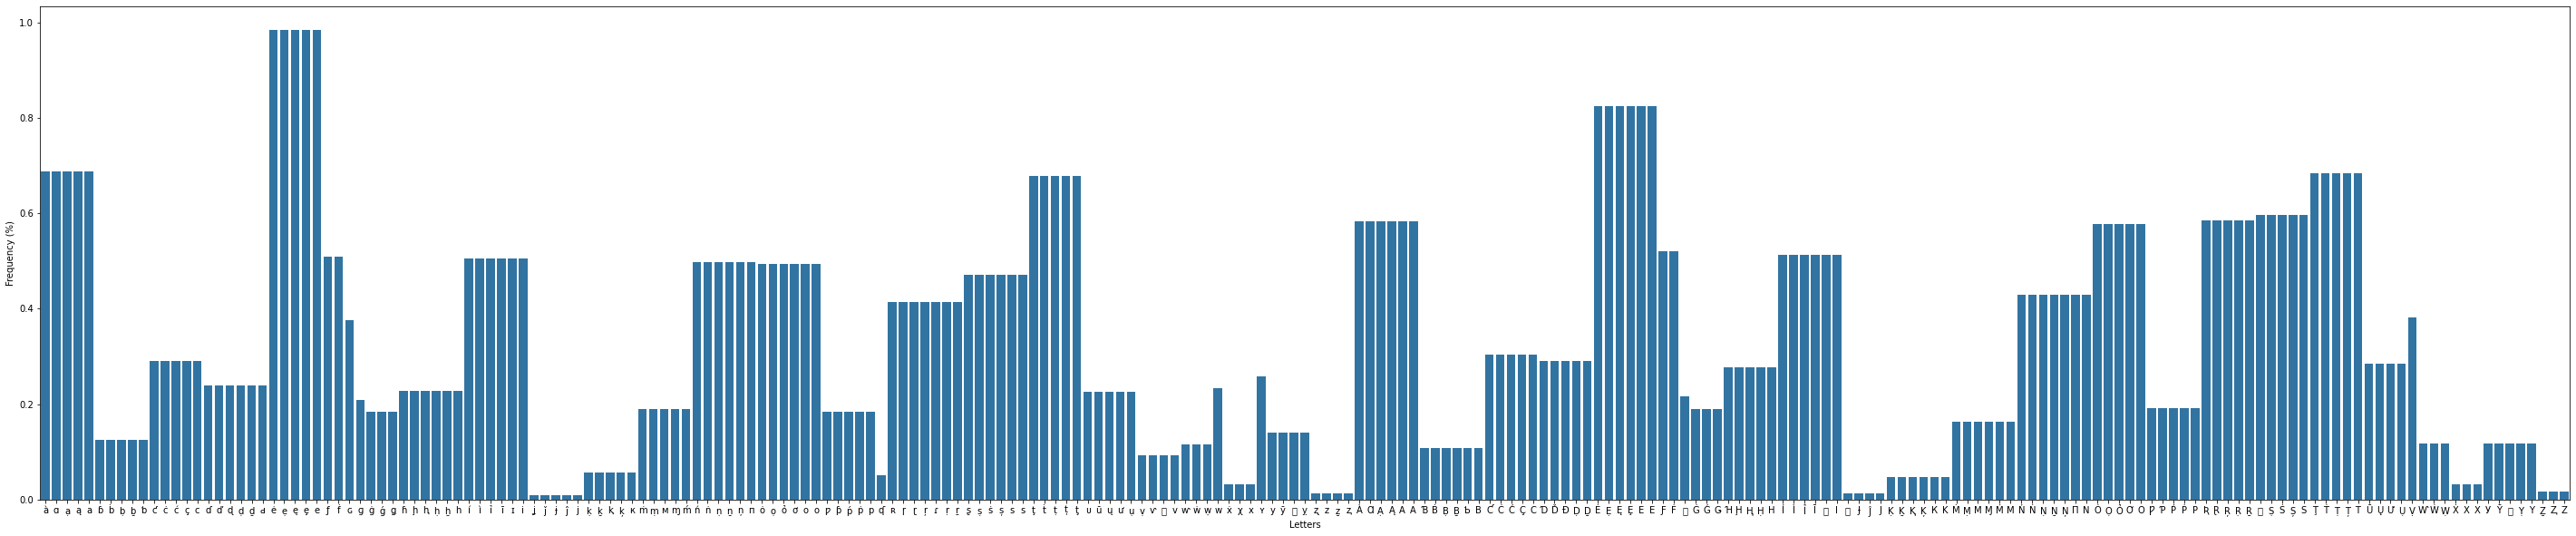

In [10]:
fig = plt.figure(figsize=(50, 10))
sns.barplot(x='letters', y='freq%', data=df)
plt.xlabel('Letters')
plt.ylabel('Frequency (%)')
plt.savefig('data/plots/glyphs_bar_plot.png')

In [19]:
with open('data/dictionary_dataset_balanced_2m.pkl', 'wb') as file:
    pickle.dump(dataset_small, file)